In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:

import splitfolders
splitfolders.ratio('./archive/Rice_Image_Dataset',output='output',seed=1337,ratio=(.8,.1,.1))

Copying files: 75000 files [05:03, 247.22 files/s]


In [3]:
BATCH=64
IMG_WIDTH=96
IMG_HEIGHT=96


In [5]:
from tensorflow.keras import preprocessing as image 
train_dir = './output/train'
test_dir = './output/test'
val_dir= './output/val'
train_load = image.image_dataset_from_directory(train_dir,
                          seed=123,
                          image_size=(IMG_WIDTH,IMG_HEIGHT),
                          batch_size=BATCH)
test_load =  image.image_dataset_from_directory(test_dir,
                          seed=123,
                          image_size=(IMG_WIDTH,IMG_HEIGHT),
                          batch_size=BATCH)
val_load = image.image_dataset_from_directory(val_dir,
                          seed=123,
                          image_size=(IMG_WIDTH,IMG_HEIGHT),
                          batch_size=BATCH)


Found 60000 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.
Found 7500 files belonging to 5 classes.


In [7]:
class_names = train_load.class_names
print(class_names)


['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


TypeError: 'module' object is not subscriptable

(64, 96, 96, 3)


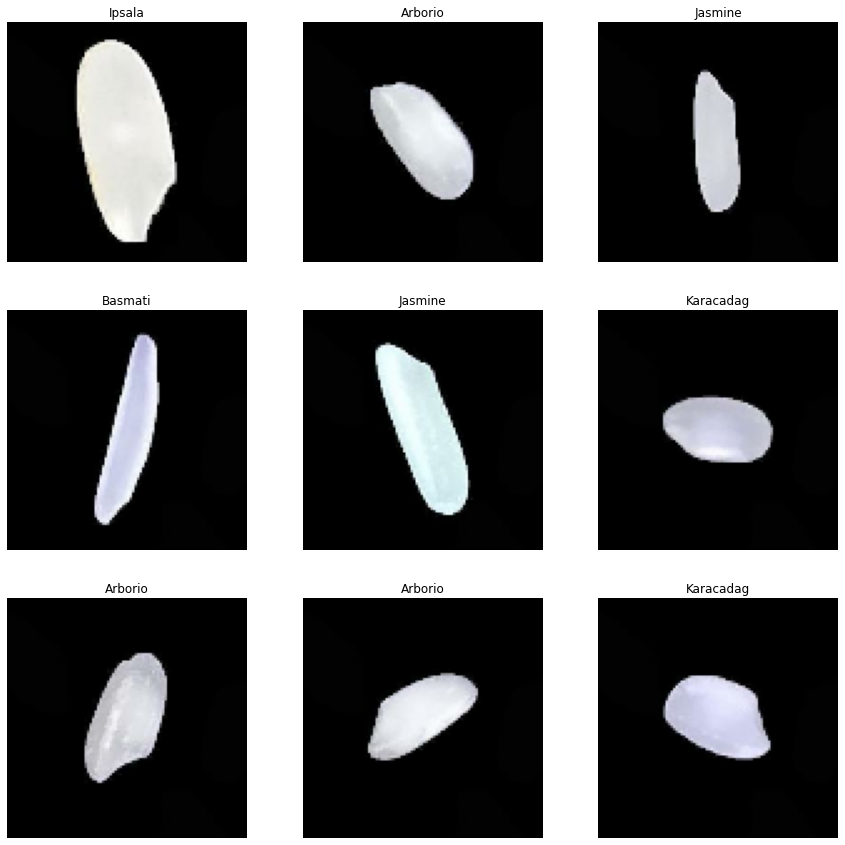

In [8]:
plt.figure(figsize=(15,15))
for image,labels in train_load.take(1):
    print(image.shape)
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        
        plt.axis('off')
plt.show()

In [23]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_load.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_load.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_load.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
#model
from tensorflow.keras.layers import experimental as ex,Conv2D,Dense,MaxPooling2D,Flatten,Dropout
data_augmentation = tf.keras.Sequential([
    ex.preprocessing.RandomFlip('horizontal',
                               input_shape=(IMG_WIDTH,IMG_HEIGHT,3)),
    ex.preprocessing.RandomRotation(0.1),
    ex.preprocessing.RandomZoom(0.1)
])
model = tf.keras.models.Sequential([
    data_augmentation,
    ex.preprocessing.Rescaling(1./255),
    Conv2D(16,3,padding='same',activation='relu'),
    MaxPooling2D(),
    
    Conv2D(32,3,padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(64,3,padding='same',activation='relu'),
    MaxPooling2D(),
    Conv2D(128,3,padding='same',activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(len(class_names))
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 96, 96, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)       

In [45]:
print(len(train_dataset))

history = model.fit(train_dataset,validation_data=val_dataset,epochs=10)

938
Epoch 1/10
938/938 [==============================] - 303s 310ms/step - loss: 0.2053 - accuracy: 0.9261 - val_loss: 0.0986 - val_accuracy: 0.9663
Epoch 2/10
938/938 [==============================] - 288s 306ms/step - loss: 0.0920 - accuracy: 0.9700 - val_loss: 0.0340 - val_accuracy: 0.9884
Epoch 3/10
938/938 [==============================] - 280s 298ms/step - loss: 0.0350 - accuracy: 0.9891 - val_loss: 0.0260 - val_accuracy: 0.9908
Epoch 4/10
938/938 [==============================] - 282s 300ms/step - loss: 0.0258 - accuracy: 0.9919 - val_loss: 0.0152 - val_accuracy: 0.9952
Epoch 5/10
938/938 [==============================] - 237s 253ms/step - loss: 0.0240 - accuracy: 0.9927 - val_loss: 0.0166 - val_accuracy: 0.9948
Epoch 6/10
938/938 [==============================] - 247s 263ms/step - loss: 0.0248 - accuracy: 0.9924 - val_loss: 0.0410 - val_accuracy: 0.9885
Epoch 7/10
938/938 [==============================] - 213s 227ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.01

In [47]:
model.save("RICE_MODEL.h5")
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']
epochs_range = range(10)
print(epochs_range)


range(0, 10)


In [ ]:
loss,acc = model.evaluate(test_dataset)
